# lifetime time calibration - store maps

### JAH  03/08/18

<i>
This notebook compues the lifetime map (scale and lifetime) and stores it in a file.
</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Jan 18 09:28:29 2019


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number                 = 6735
input_dst_filenames        = [f"$IC_DATA/{run_number}/kdsts/kdst_{run_number}_filtered.h5"]
#                              f"$IC_DATA/dsts/kdst_{run_number}_1_filtered.h5",
#                              f"$IC_DATA/dsts/kdst_{run_number}_2_filtered.h5",
#                              f"$IC_DATA/dsts/kdst_{run_number}_3_filtered.h5"
#                             ]
correction_filename         = f"$IC_DATA/maps/kr_corrections_run{run_number}.h5"

Rrange  =    0., 200.
Zrange  =    0., 550.
XYrange = -200., 200.
E0range = 6.5e3, 13.5e3
LTrange = 2.0e3,  6.5e3
Chrange =     0, 20.

XYnbins      =  60


### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf

from invisible_cities.core .core_functions import in_range

from krcal.dev.table_info import RunInfo
from krcal.dev.table_info import MapInfo

import krcal.utils.hst_extend_functions as hst
import krcal.utils.plt_functions        as apt
import krcal.utils.kdst_functions       as kdstf
import krcal.dev.akr_functions          as akr
import krcal.dev.corrections            as corrections

In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
input_dst_filenames           = [os.path.expandvars(fi) for fi in input_dst_filenames]
print(input_dst_filenames)
correction_filename           = os.path.expandvars(correction_filename)

['/Users/hernando/investigacion/NEXT/data/runIV//6735/kdsts/kdst_6735_filtered.h5']


In [7]:
dst = kdstf.load_dsts(input_dst_filenames, "DST", "Events")

## Read data

In [8]:
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 191708 
Total number of events: 191708


## Relevant data and corrections

In [9]:
X   = dst.X   .values
Y   = dst.Y   .values
Z   = dst.Z   .values
R   = dst.R   .values
Phi = dst.Phi .values
S2e = dst.S2e .values
S2q = dst.S2q .values
T   = dst.time.values
TH  = (T - T.min())/3600. # time in hours

## Selection

In [10]:
sel_r = in_range(R, *Rrange)
sel_z = in_range(Z, *Zrange)
sel   = sel_r & sel_z

In [11]:
Znbins = 50
Enbins, Erange = 50, (6e3, 14e3)

## Study map 

In [12]:
XYa = hst.Vaxis( XYrange, nbins = XYnbins)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


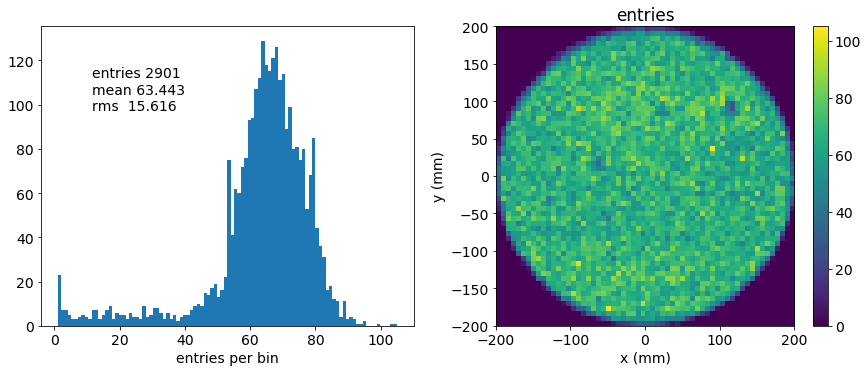

In [13]:
c = hst.Canvas(1, 2)
nevt, *_ = hst.hist2d(X[sel], Y[sel], (XYa.bins, XYa.bins), canvas=c(2), 
                      xylabels = ('x (mm)', 'y (mm)', 'entries'))
plt.colorbar()
oks = nevt > 0
hst.hist(nevt[oks].flatten(), 100, canvas = c(1), xylabels = ('entries per bin', ''));
plt.tight_layout()

In [14]:
xye0, xylt, xychi2, xyok = akr.ltmap_lsqfit(X[sel], Y[sel], Z[sel], S2e[sel], XYa.bins)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


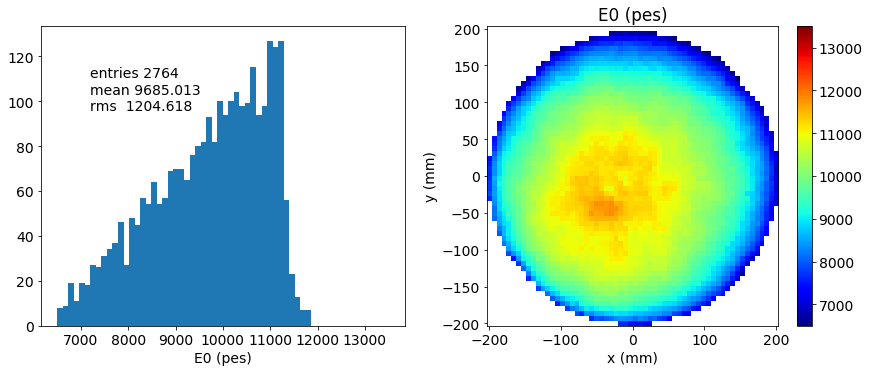

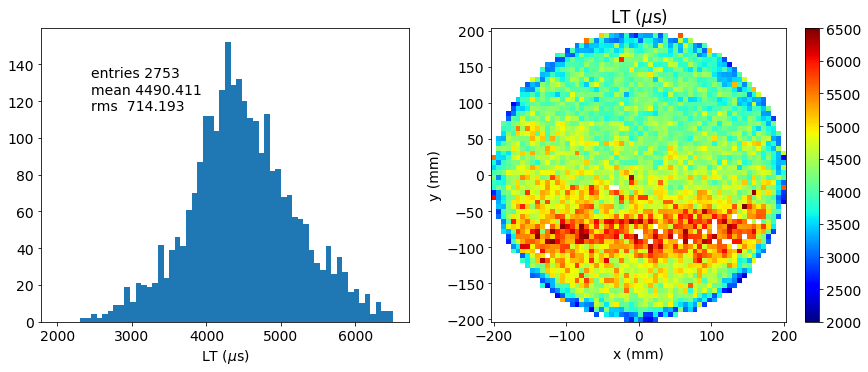

In [15]:
apt.plt_xymap(XYa.centers, XYa.centers, xye0.value, xyok, XYa.nbins, E0range, 'E0 (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xylt.value, xyok, XYa.nbins, LTrange, 'LT ($\mu$s)');

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


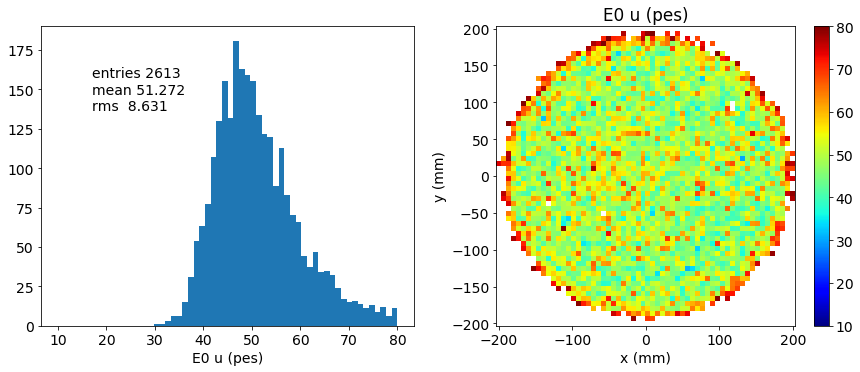

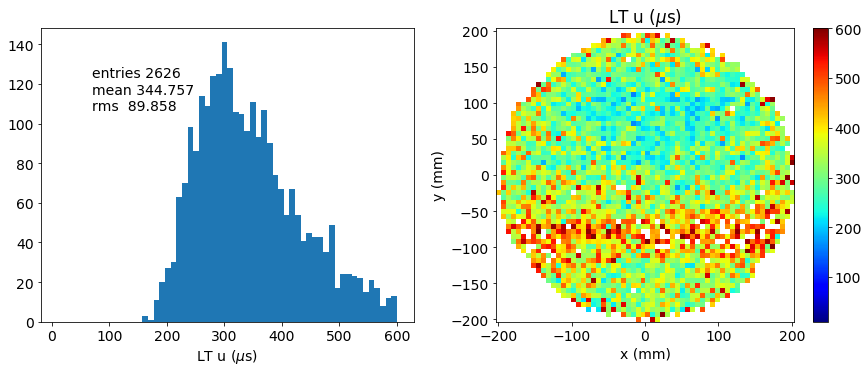

In [16]:
E0urange = (10., 80.)
LTurange = (10., 600.)
apt.plt_xymap(XYa.centers, XYa.centers, xye0.uncertainty, xyok, XYa.nbins, E0urange, 'E0 u (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xylt.uncertainty, xyok, XYa.nbins, LTurange, 'LT u ($\mu$s)');

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


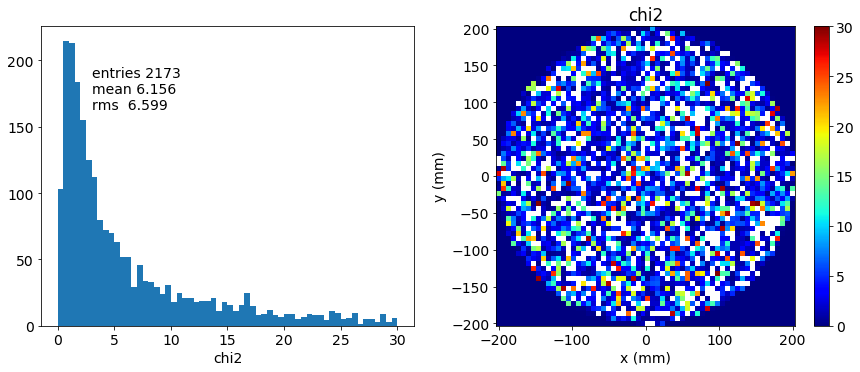

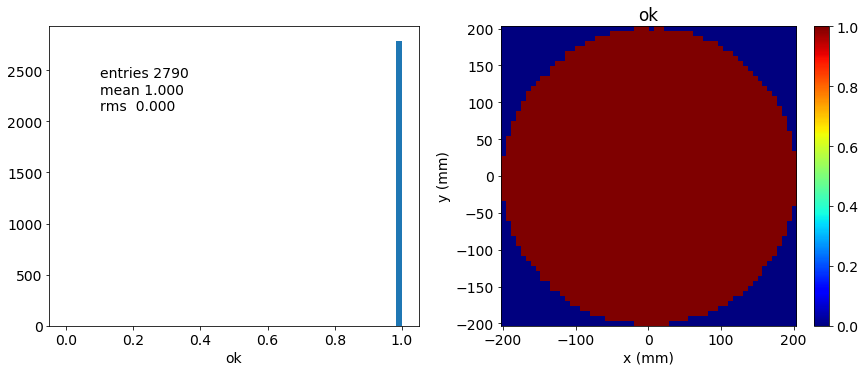

In [17]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
E0urange = (0., 100.)
LTurange = (0., 100.)
apt.plt_xymap(XYa.centers, XYa.centers, xychi2, xyok, XYa.nbins, (0., 30.), 'chi2');
apt.plt_xymap(XYa.centers, XYa.centers, xyok, xyok, XYa.nbins, (0., 1.), 'ok');

In [18]:
xyq0, xyqlt, xyqchi2, xyqok = akr.ltmap_lsqfit(X[sel], Y[sel], Z[sel], S2q[sel], XYa.bins)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


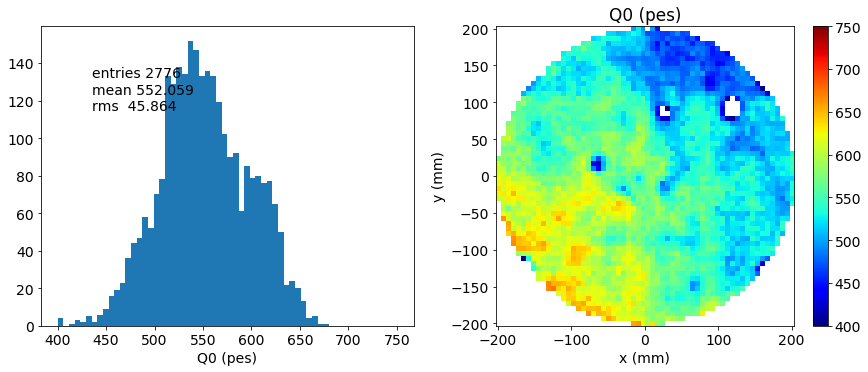

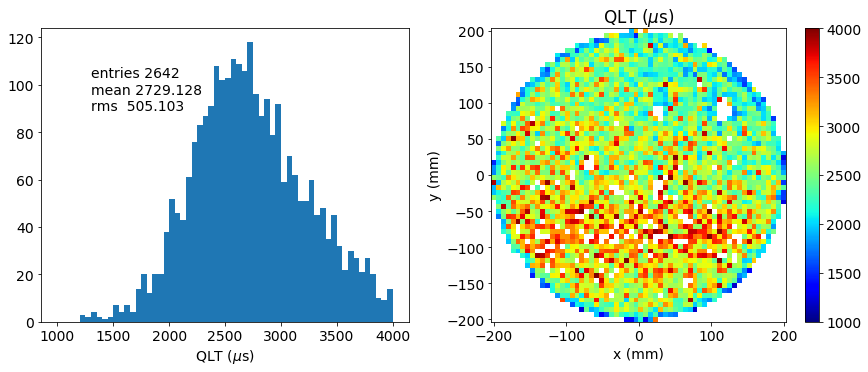

In [19]:
QE0range = (0.4e3, 0.75e3)
QLTrange = (1.0e3, 4e3)
apt.plt_xymap(XYa.centers, XYa.centers, xyq0.value, xyqok, XYa.nbins, QE0range, 'Q0 (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xyqlt.value, xyqok, XYa.nbins, QLTrange, 'QLT ($\mu$s)');

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6830: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


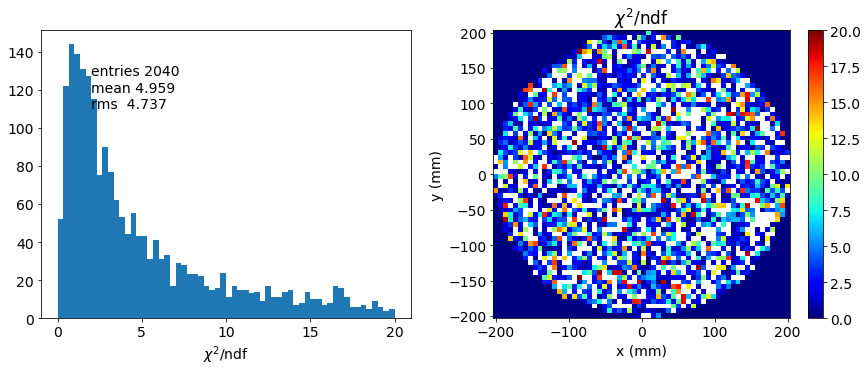

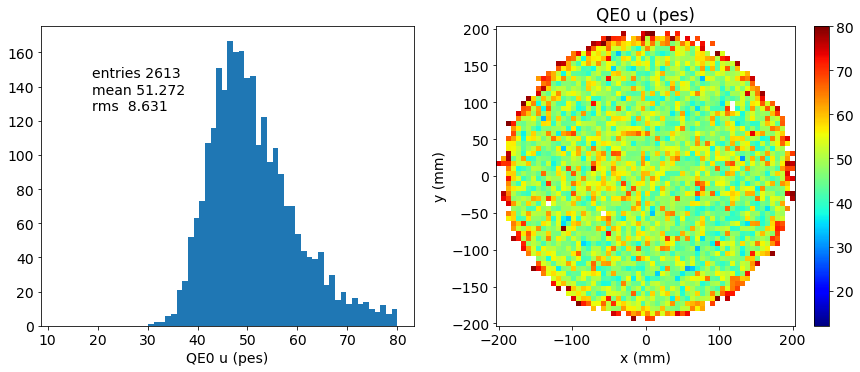

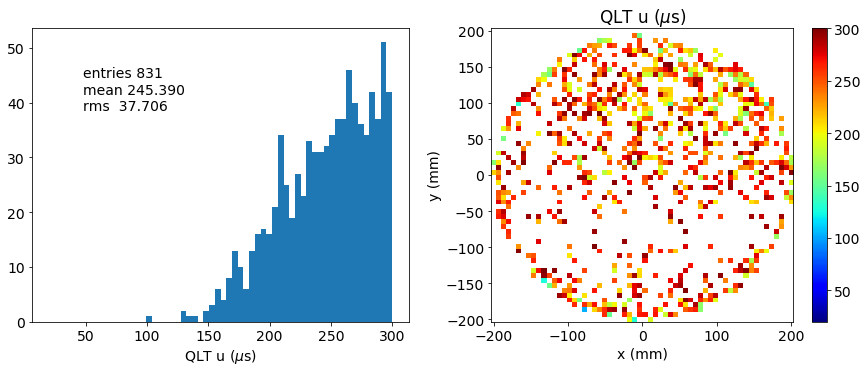

In [20]:
apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, XYa.nbins, Chrange, '$\chi^2$/ndf')
QE0urange = (12., 80.)
QLTurange = (20., 300.)
apt.plt_xymap(XYa.centers, XYa.centers, xye0.uncertainty , xyqok, XYa.nbins, QE0urange, 'QE0 u (pes)');
apt.plt_xymap(XYa.centers, XYa.centers, xyqlt.uncertainty, xyqok, XYa.nbins, QLTurange, 'QLT u ($\mu$s)');

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


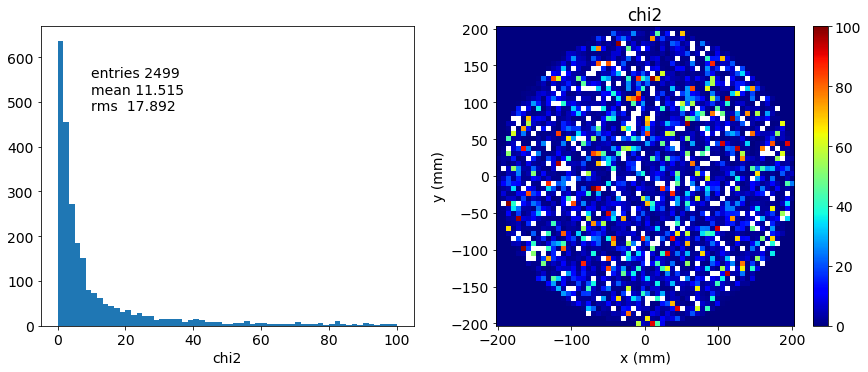

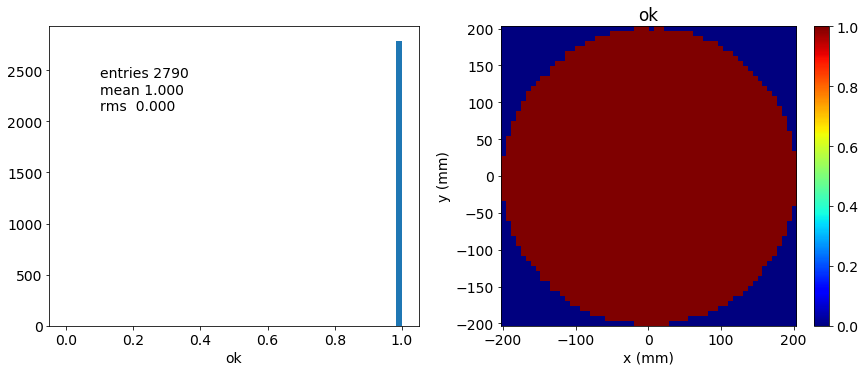

In [21]:
#apt.plt_xymap(XYa.centers, XYa.centers, xychi2    , xyok, Chnbins, Chrange, '$\chi^2$/ndf')
apt.plt_xymap(XYa.centers, XYa.centers, xyqchi2, xyqok, XYa.nbins, (0., 100.), 'chi2');
apt.plt_xymap(XYa.centers, XYa.centers, xyqok  , xyqok, XYa.nbins, (0., 1.), 'ok');

In [22]:
Trange = (T.min(), T.max()) 
corrections.write_lifetime_correction(correction_filename, run_number, Trange, XYa.bins, 
                                      xye0, xylt, xyok, xyq0, xyqlt, xyqok, nevt)
corrections.write_geometry_correction(correction_filename, run_number, Trange, XYa.bins, 
                                      xye0, xyok, xyq0, xyqok, nevt)

writing corrections : /Users/hernando/investigacion/NEXT/data/runIV//maps/kr_corrections_run6735.h5


In [23]:
print('Done!')

Done!
